## Testing the electrophysiological properties : FS neurons

We discuss the properties of three types of GABAergic interneurons - PV expressing, SST expressing and VIP expressing. However, the electrophysiological properties of these are extracted from the two types of neurons called fast spiking (fs) and non-fast spiking (nfs) neurons, from the literature.

In [1]:
%matplotlib notebook

import brian2 as b2
import numpy
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from input_factory import get_step_current, get_ou_current
from plot_tools import plot_voltage_and_current_traces

In [2]:
model_eqs = '''
dv/dt = (-gL*(v-v_rest) - w1 - w2 + I_ext(t))/C : volt

dw1/dt = -w1/tau_w1 : amp
dw2/dt = -w2/tau_w2 : amp

dvt1/dt = -vt1/tau_vt1 : volt
dvt2/dt = -vt2/tau_vt2 : volt
 
vt = v_thresh + vt1 + vt2 : volt
lambda_t = lambda_0*exp((v-vt)/del_v): Hz
'''
reset_eqs = '''
v = v_reset
w1+=amp_w1
w2+=amp_w2
vt1+=amp_vt1
vt2+=amp_vt2
'''

In [3]:
nfs_df = pd.read_csv('data/nfs.txt',header = None)
nfs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']
fs_df = pd.read_csv('data/fs.txt',header = None)
fs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']

In [4]:
fs_df

,C (nF),gL (usiemens),v_rest (mV),v_reset (mV),tau_refr (ms),v_thresh (mV),del_v (mV),amp_w1 (nA),tau_w1 (ms),amp_w2 (nA),tau_w2 (ms),amp_vt1 (mV),tau_vt1 (ms),amp_vt2 (mV),tau_vt2 (ms)
0,0.093900,0.010000,-67.500,-50.000,4,-51.000,0.10000,0.111610,36.860,0.072640,61.760,0.00000,1.000,0.000000,1.000
1,0.049873,0.005796,-72.135,-56.112,4,-49.064,0.58708,0.045860,17.158,-0.013761,71.309,2.27260,18.146,-1.174800,18.146
2,0.056424,0.006658,-70.121,-60.106,4,-49.251,0.51066,0.738690,40.800,-0.682990,43.726,0.11264,1000.000,0.339650,111.860
3,0.047600,0.013032,-62.712,-53.610,4,-46.067,0.97566,0.067409,11.011,-0.011931,169.550,16.42100,61.974,-16.876000,59.358
4,0.035515,0.006580,-66.289,-51.885,4,-41.730,0.64993,0.048545,20.590,-0.013581,138.650,2.78930,61.094,-1.847800,61.094
5,0.038200,0.005937,-67.806,-45.313,4,-41.619,0.75960,0.051750,34.338,-0.012963,118.450,-4.08740,66.752,5.955600,66.752
6,0.048262,0.010784,-72.042,-56.229,4,-46.529,0.74107,0.101660,22.626,-0.032768,108.840,3.44750,7.197,0.172790,417.120
7,0.050049,0.005742,-72.376,-55.588,4,-49.345,0.58798,0.047068,16.881,-0.014306,68.874,4.21170,70.676,-3.734000,70.676
8,0.056894,0.006680,-70.036,-60.106,4,-49.107,0.49588,0.754400,41.290,-0.697830,44.256,0.40880,176.850,0.001768,176.760
9,0.048262,0.010784,-72.042,-56.229,4,-46.550,0.74107,0.101660,22.626,-0.032768,108.840,3.44750,7.197,0.172790,417.120


In [5]:
print('R_in_fs',1/fs_df.iloc[0,:][1])
print('tau-fs',fs_df.iloc[0,:][0]/fs_df.iloc[0,:][1])

R_in_fs 100.0
tau-fs 9.39


For PV positive neurons, we use fast-spiking properties

In [6]:
fs_param = fs_df.iloc[0,:] #set which value to try out, set any if running through all
C = fs_param['C (nF)'] * b2.nF
gL = fs_param['gL (usiemens)'] * b2.usiemens
v_rest = fs_param['v_rest (mV)'] * b2.mV
v_reset = fs_param['v_reset (mV)'] * b2.mV
tau_refr = fs_param['tau_refr (ms)'] * b2.ms

v_thresh = fs_param['v_thresh (mV)'] * b2.mV
del_v = fs_param['del_v (mV)'] * b2.mV
amp_w1 = fs_param['amp_w1 (nA)'] * b2.nA
tau_w1 = fs_param['tau_w1 (ms)'] * b2.ms
amp_w2 = fs_param['amp_w2 (nA)'] * b2.nA
tau_w2 = fs_param['tau_w2 (ms)'] * b2.ms

amp_vt1 = fs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1 = fs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2 = fs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2 = fs_param['tau_vt2 (ms)'] * b2.ms

In [7]:
b2.start_scope()
## amplitude to be played with 
# I_ext = get_step_current(t_start = 200, t_end = 700, unit_time = 1*b2.ms, amplitude = 0.3*b2.namp)
I_ext = get_ou_current(15,Delta_sigma=10.0,sigma_0=10.0)
lambda_0 = 10 * b2.kHz
time = 1000 * b2.ms

PV = b2.NeuronGroup(1, model = model_eqs, reset = reset_eqs, threshold = "v > vt",refractory = tau_refr, method = 'rk4')
PV.v = v_rest
voltage_monitor_pv = b2.StateMonitor(PV, ['v', 'vt','w1','w2'], record=True)
spike_monitor_pv = b2.SpikeMonitor(PV)

pv_monitors = [voltage_monitor_pv, spike_monitor_pv]
print("Before simulation" , datetime.datetime.now())

pv_net = b2.Network(PV)
pv_net.add(pv_monitors)
pv_net.run(time)

print("After simulation" , datetime.datetime.now())

Before simulation 2018-07-26 16:37:05.691664
After simulation 2018-07-26 16:37:15.881259


<IPython.core.display.Javascript object>


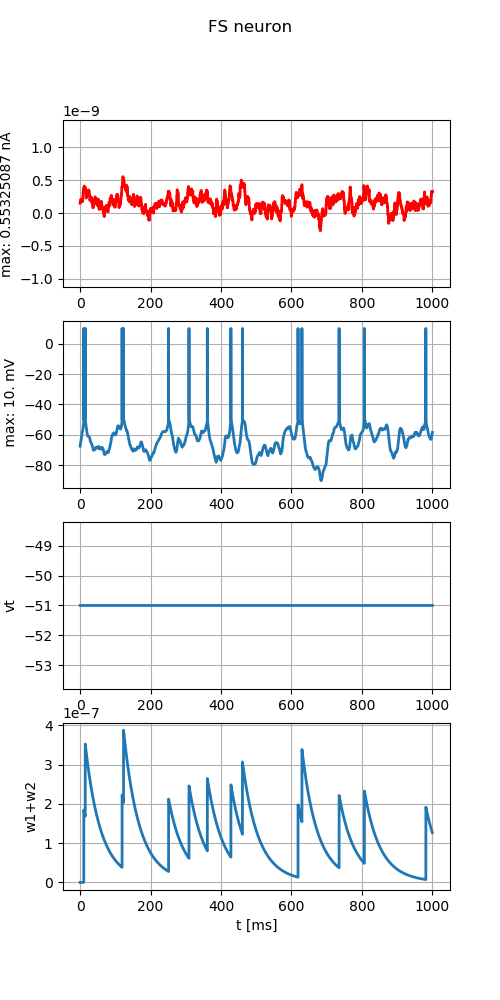

In [8]:
fig = plt.figure(figsize=(5,10))
plot_voltage_and_current_traces(voltage_monitor_pv, spike_monitor_pv,
                                I_ext,title='FS neuron')
plt.show()

In [9]:
# fig.savefig('../figs/25_fsou.jpg')